In [26]:
# link to use: https://towardsdatascience.com/faq-build-a-handwritten-text-recognition-system-using-tensorflow-27648fb18519
# convert image to character segments: https://stackoverflow.com/questions/10964226/how-to-convert-an-image-into-character-segments
# KMNIST convolutional NN: https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py


## Preprocessing: Image Segmentation and Contrast Enhancement

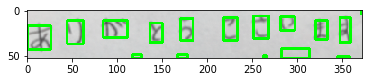

In [159]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy.stats import mode


# Load the image
img = cv2.imread('thanks.png')

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# smooth the image to avoid noises
gray = cv2.medianBlur(gray,5)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray,255,1,1,61,2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

# apply some dilation and erosion to join the gaps
# thresh = cv2.dilate(thresh,None,iterations = 3)
# thresh = cv2.erode(thresh,None,iterations = 2)

# clean up the neighbours
# majority based label cleanup
#plt.imshow(thresh)


def cleanup(img):
    clean = np.zeros(np.shape(img))
    print(np.shape(img))
    for i in range(1, len(img)-1):
        for j in range(1, len(img[0])-1):
            neighbors = [img[i][j-1], 
                         img[i][j+1], 
                         img[i-1][j+1], 
                         img[i-1][j-1], 
                         img[i-1][j], 
                         img[i+1][j],
                         img[i+1][j+1], 
                         img[i+1][j-1]]
            if img[i][j] != 0 and 0 in neighbors:
                clean[i][j] = 0
            else:
                clean[i][j] = img[i][j]
    return clean

# thresh = cleanup(thresh)
# print(type(thresh))
#plt.imshow(thresh)



thresh = cv2.dilate(thresh,None, iterations = 4, anchor = (-1, 1))
plt.imshow(thresh)
thresh = cv2.erode(thresh,None, iterations = 5)
plt.imshow(thresh)

#plt.imshow(thresh)


# Find the contours
im, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

# # For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)


plt.imshow(img)

# CNN for Hiragana Classification using KMNIST-49

In [160]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist/kmnist-train-imgs.npz')
x_test = load('kmnist/kmnist-test-imgs.npz')
y_train = load('kmnist/kmnist-train-labels.npz')
y_test = load('kmnist/kmnist-test-labels.npz')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Using TensorFlow backend.


60000 train samples, 10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 172s 3ms/step - loss: 0.4550 - acc: 0.8590 - val_loss: 0.3696 - val_acc: 0.8919
Train loss: 0.12027810399966936
Train accuracy: 0.9652
Test loss: 0.36957322931885717
Test accuracy: 0.8919


(28, 28)
(10000, 28, 28, 1)


10000

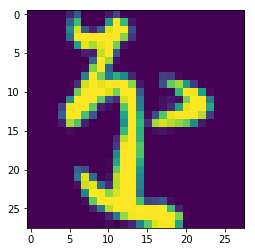

In [162]:
print(np.shape(x_train[0,:,:,0]))
print(np.shape(x_test))
plt.imshow(x_test[1,:,:,0])

x = model.predict(x_test)

len(x)



In [165]:
x[0]


array([0.00327383, 0.02412042, 0.04271048, 0.5784874 , 0.00357403,
       0.3139228 , 0.00795085, 0.00381819, 0.01098733, 0.01115467],
      dtype=float32)